In [113]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.io.netcdf
from os.path import join
import xarray as xr
import numpy as np
from mom6_helper import coarse_grain_h, coarse_grain_u, coarse_grain_v, \
        get_2d_index_h_to_staggered, poly_features_uv_staggered, \
        zb2020, tendencies_from_subgrid
import sys
sys.path.append('../pyqg_test')
from util import spectrum_regression, window

def spectral_energy_contribution_staggered(u, v, du, dv, dx, dy, WINDOW = True):
    if len(u.shape) != len(v.shape) or \
       du.shape != u.shape or dv.shape != v.shape or \
       len(du.shape) > 4:
        print('The dimensionality of u, v, du, dv should be consistent!')
        return None
    if u.shape == 2:
        for var in ['u', 'v', 'du', 'dv']:
            eval('{0} = {0}[np.newaxis, np.newaxis, ...]'.format(var))
    elif u.shape == 3:
        for var in ['u', 'v', 'du', 'dv']:
            eval('{0} = {0}[np.newaxis, ...]'.format(var))
    Nt, Nz, _, _ = u.shape
    u_h  = (u[:, :, :, 0:-1] + u[:, :, :, 1:]) / 2
    v_h  = (v[:, :, 0:-1, :] + v[:, :, 1:, :]) / 2
    du_h = (du[:, :, :, 0:-1] + du[:, :, :, 1:]) / 2
    dv_h = (dv[:, :, 0:-1, :] + dv[:, :, 1:, :]) / 2

    dKE_spec = np.zeros_like(u_h)
    for t in range(Nt):
        for k in range(Nz):
            if WINDOW:
                S_u  = np.fft.fft2(window(u_h [t, k, ...], DO_X = True, MEAN = True).squeeze())
                S_v  = np.fft.fft2(window(v_h [t, k, ...], DO_X = True, MEAN = True).squeeze())
                S_du = np.fft.fft2(window(du_h[t, k, ...], DO_X = True, MEAN = True).squeeze())
                S_dv = np.fft.fft2(window(dv_h[t, k, ...], DO_X = True, MEAN = True).squeeze())
            else:
                S_u  = np.fft.fft2(u_h [t, k, ...])
                S_v  = np.fft.fft2(v_h [t, k, ...])
                S_du = np.fft.fft2(du_h[t, k, ...])
                S_dv = np.fft.fft2(dv_h[t, k, ...])
            dKE_spec[t, k, ...] = np.real(S_u * np.conj(S_du) + S_v * np.conj(S_dv))
    dKE_spec_mean = dKE_spec.mean(0)
    
    bins_x = []; S_x = []
    for k in range(Nz):
        _, temp_bins, temp_S = spectrum_regression(dKE_spec_mean[k, ...], oneD = False, dx = dx, dy = dy, 
                                                   regress = False, bin_type = 'linear', regular_bin = True)
        bins_x.append(temp_bins)
        S_x.append(temp_S)

    return bins_x, S_x

def spectral_energy(u, dx, dy, WINDOW = True):
    if u.shape == 2:
        u = u[np.newaxis, np.newaxis, ...]
    elif u.shape == 3:
        u = u[np.newaxis, ...]
    Nt, Nz, _, _ = u.shape

    u_spec = np.zeros_like(u)
    for t in range(Nt):
        for k in range(Nz):
            if WINDOW:
                S_u  = np.fft.fft2(window(u[t, k, ...], DO_X = True, MEAN = True).squeeze())
            else:
                S_u  = np.fft.fft2(u[t, k, ...])
            u_spec[t, k, ...] = np.abs(S_u)**2
    u_spec_mean = u_spec.mean(0)
    
    bins_x = []; S_x = []
    for k in range(Nz):
        _, temp_bins, temp_S = spectrum_regression(u_spec_mean[k, ...], oneD = False, dx = dx, dy = dy, 
                                                   regress = False, bin_type = 'linear', regular_bin = True)
        bins_x.append(temp_bins)
        S_x.append(temp_S)
    return bins_x, S_x

def plot_spectral_contribution(ks, dSs, labels, title_part, dxs = None):
    fig = plt.figure(figsize = [6, 5])
    for i in range(len(ks[0])):
        plt.subplot(2, 1, i+1)
        plt.plot(ks[-1][i], np.zeros_like(ks[-1][i]), '--', color = 'grey', alpha = 0.5)
        for j, k in enumerate(ks):
            l1 = plt.plot(ks[j][i], dSs[j][i], label = labels[j])
            if dxs:
                plt.scatter(np.pi/dxs[j], 0, marker = 'x', color = l1[0].get_color())
        plt.xlabel(r'$k$ (m$^{-1}$)')
        plt.xscale('log')
        if i == 0:
            plt.title(title_part + ', upper layer')
        elif i == 1:
            plt.title(title_part + ', lower layer')
        plt.legend(loc = 'best')
    plt.tight_layout()
    
def get_mom_data(data_path, filename_part, ts):
    ds_list = [];
    for i in ts:
        ds_list.append(xr.open_mfdataset(join(data_path, filename_part).format(i), 
                                         combine="nested", concat_dim="Time"))
    ds = xr.concat(ds_list, "Time")
    for temp_ds in ds_list:
        del temp_ds
    del ds_list
    return ds

def cal_spectral_contribution_diff_res(Rs, ts, path_pattern, OFFLINE_TENDENCIES = True):
    ks = []; dSs = []; labels = []
    for r in Rs:
        data_path = path_pattern.format(str(r))
        ds = get_mom_data(data_path, 'prog__00{0}?_???.nc', ts)

        u = np.array(ds.u.data.squeeze())
        v = np.array(ds.v.data.squeeze())
        u[:, :, :, 0] = 0; u[:, :, :, -1] = 0
        v[:, :, 0, :] = 0; v[:, :, -1, :] = 0

        dx = 1/r/180*np.pi*6.378E+06; dy = dx

        if OFFLINE_TENDENCIES:
            du_zb2020, dv_zb2020, uu_sub_zb2020, vv_sub_zb2020, uv_sub_zb2020 = \
                                            zb2020(u, v, dx = dx, dy = dy, kappa = -4.87e8 * 0.5)
        else:
            ds_mom = get_mom_data(data_path, 'mom__00{0}?_???.nc', ts)
            du_zb2020 = np.array(ds_mom.ZB2020u.squeeze())
            dv_zb2020 = np.array(ds_mom.ZB2020v.squeeze())
        
        lim = 1
        k_zb2020, dS_zb2020 = spectral_energy_contribution_staggered(
            u[:, :, lim:-lim, lim:-lim], v[:, :, lim:-lim, lim:-lim], 
            du_zb2020[:, :, lim:-lim, lim:-lim], dv_zb2020[:, :, lim:-lim, lim:-lim], dx, dy, WINDOW = True)

        for i in range(len(dS_zb2020)):
            dS_zb2020[i] = dS_zb2020[i] / abs(dS_zb2020[i]).sum()
        ks.append(k_zb2020)
        dSs.append(dS_zb2020)
        labels.append('R' + str(r))
    return ks, dSs, labels

In [2]:
## Read in data
data_path = '/scratch/zl1574/mom6_simulation/double_gyre_R16_cartesian_100yr/output/'
ds_list = []; 
for i in np.arange(6, 10):
    ds_list.append(xr.open_mfdataset(join(data_path, 'prog__00{0}?_???.nc').format(i), 
                                     combine="nested", concat_dim="Time"))
ds = xr.concat(ds_list, "Time")
for temp_ds in ds_list:
    del temp_ds
del ds_list

In [3]:
## Set coarse-grain scales
n_scale = 4 # Must be multiples of 2
Nt, Nz, Ny, Nx = ds.h.shape
Nx_c = int(Nx/n_scale)
Ny_c = int(Ny/n_scale)
u = np.array(ds.u.data.squeeze())
v = np.array(ds.v.data.squeeze())
## Set the boundary of velocity fields
u[:, :, :, 0] = 0; u[:, :, :, -1] = 0
v[:, :, 0, :] = 0; v[:, :, -1, :] = 0

In [4]:
# Coarse-grain u and v fields
u_c = coarse_grain_u(u, n_scale)
v_c = coarse_grain_v(v, n_scale)

t = 0
t = 100
t = 200
t = 300
t = 400
t = 0
t = 100
t = 200
t = 300
t = 400


<IPython.core.display.Javascript object>


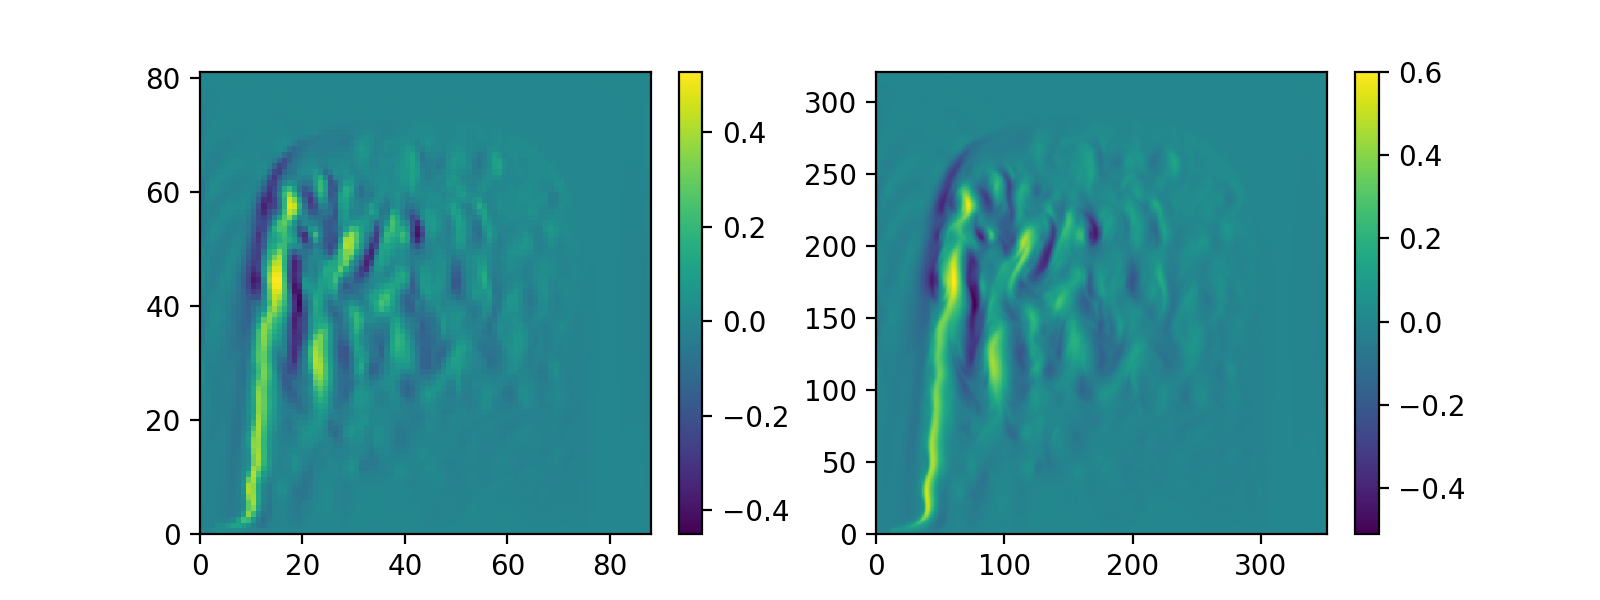

In [11]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.pcolormesh(v_c[-1, 0, :, :]); plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(v[-1, 0, :, :]); plt.colorbar()

## Get subgrid flux


In [6]:
# Interpolate to the center of the grid (h point in C-grid)
u_ch = (u_c[:, :, :, 0:-1] + u_c[:, :, :, 1:]) / 2
v_ch = (v_c[:, :, 0:-1, :] + v_c[:, :, 1:, :]) / 2
u_h  = (u  [:, :, :, 0:-1] + u  [:, :, :, 1:]) / 2
v_h  = (v  [:, :, 0:-1, :] + v  [:, :, 1:, :]) / 2

# Calculate coarse-grained fluxes
u_h_coarse  = coarse_grain_h(u_h, n_scale)
v_h_coarse  = coarse_grain_h(v_h, n_scale)
uv_h_coarse = coarse_grain_h(u_h*v_h, n_scale)
u2_h_coarse = coarse_grain_h(u_h**2, n_scale)
v2_h_coarse = coarse_grain_h(v_h**2, n_scale)

# Calculate subgrid fluxes
uv_subgrid = u_ch*v_ch - uv_h_coarse
uu_subgrid = u_ch**2 - u2_h_coarse
vv_subgrid = v_ch**2 - v2_h_coarse

### Example 1: let subgrid-scale forcing on h grid, and use staggered u, v to predict the forcing values

In [7]:
## Get stencil locations
# r can be chosen from 0.5, np.sqrt(5)/2, 1.5, np.sqrt(13)/2
# It seems that np.sqrt(5)/2 is the best choice
r = np.sqrt(5)/2
u_ind, v_ind = get_2d_index_h_to_staggered(r)
LINEAR_TERMS = False; CROSS_TERMS = True

## Get normalized features
u1, v1 = u_c[:, 0, ...].squeeze().copy(), v_c[:, 0, ...].squeeze().copy()
u2, v2 = u_c[:, 1, ...].squeeze().copy(), v_c[:, 1, ...].squeeze().copy()

u1_std = u1.std(); u2_std = u2.std()
v1_std = v1.std(); v2_std = v2.std()

# Set velocity standard deviation to be the same
u2_std = u1_std; v1_std = u1_std; v2_std = u1_std

# Normalize velocity features
u1 /= u1_std; u2 /= u2_std
v1 /= v1_std; v2 /= v2_std

# Get polynomial features
X_feature_u1, var_list, bnd = poly_features_uv_staggered(u1, v1, u_ind, v_ind, 
                                        CROSS_TERMS = CROSS_TERMS, LINEAR_TERMS = LINEAR_TERMS)
X_feature_u2, _, _ = poly_features_uv_staggered(u2, v2, u_ind, v_ind, 
                                        CROSS_TERMS = CROSS_TERMS, LINEAR_TERMS = LINEAR_TERMS)

## Get subgrid forcing as targets
uu1_subgrid = uu_subgrid[:, 0, bnd:Ny_c-bnd, bnd:Nx_c-bnd].squeeze().copy()
uv1_subgrid = uv_subgrid[:, 0, bnd:Ny_c-bnd, bnd:Nx_c-bnd].squeeze().copy()
vv1_subgrid = vv_subgrid[:, 0, bnd:Ny_c-bnd, bnd:Nx_c-bnd].squeeze().copy()
uu2_subgrid = uu_subgrid[:, 1, bnd:Ny_c-bnd, bnd:Nx_c-bnd].squeeze().copy()
uv2_subgrid = uv_subgrid[:, 1, bnd:Ny_c-bnd, bnd:Nx_c-bnd].squeeze().copy()
vv2_subgrid = vv_subgrid[:, 1, bnd:Ny_c-bnd, bnd:Nx_c-bnd].squeeze().copy()

# Get target standard deviations
u1_subgrid_std = uv1_subgrid.std()
u2_subgrid_std = uv2_subgrid.std()

# Set subgrid standard deviation to be the same
u2_subgrid_std = u1_subgrid_std

# Normalize targets
uu1_subgrid /= u1_subgrid_std
uv1_subgrid /= u1_subgrid_std
vv1_subgrid /= u1_subgrid_std
uu2_subgrid /= u2_subgrid_std
uv2_subgrid /= u2_subgrid_std
vv2_subgrid /= u2_subgrid_std

In [8]:
# Train both layers
X_feature_u = np.concatenate([X_feature_u1, X_feature_u2], axis = 1)
X_target1 = np.concatenate([uu1_subgrid, uu2_subgrid], axis = 0).reshape(1, -1)
X_target2 = np.concatenate([uv1_subgrid, uv2_subgrid], axis = 0).reshape(1, -1)
X_target3 = np.concatenate([vv1_subgrid, vv2_subgrid], axis = 0).reshape(1, -1)

# Flatten features and targets
X_feature_u = X_feature_u.reshape([X_feature_u.shape[0], -1])
X_target_u = np.concatenate([X_target1, X_target2, X_target3], axis = 0)

# Delete unnecessary arrays
del X_feature_u1, X_feature_u2, X_target1, X_target2, X_target3

## Do polynomial training

In [9]:
N_train = 100000; N_test = 40000
N_length = max(X_feature_u.shape[-1], N_train + N_test)
ind = np.random.choice(N_length, N_train + N_test, replace=False)
data_u = [X_feature_u[:, ind[0:N_train]].T, X_target_u[:, ind[0:N_train]].T, 
          X_feature_u[:, ind[N_train: ]].T, X_target_u[:, ind[N_train: ]].T]

In [10]:
# Non-conservative case
import sys
sys.path.append('../pyqg_test')
from models import train_polynet
sparse_regression = True
L1_lambda = 0.0005
net_poly, train_loss_poly, test_loss_poly = train_polynet(data_u, Poly_init = False, 
            sparse_regression = sparse_regression, L1_lambda = L1_lambda, n_epochs = 50, conserve_energy = False)

epoch = 50, traing loss = 2.119594e-01, test loss = 1.857220e-01



<IPython.core.display.Javascript object>


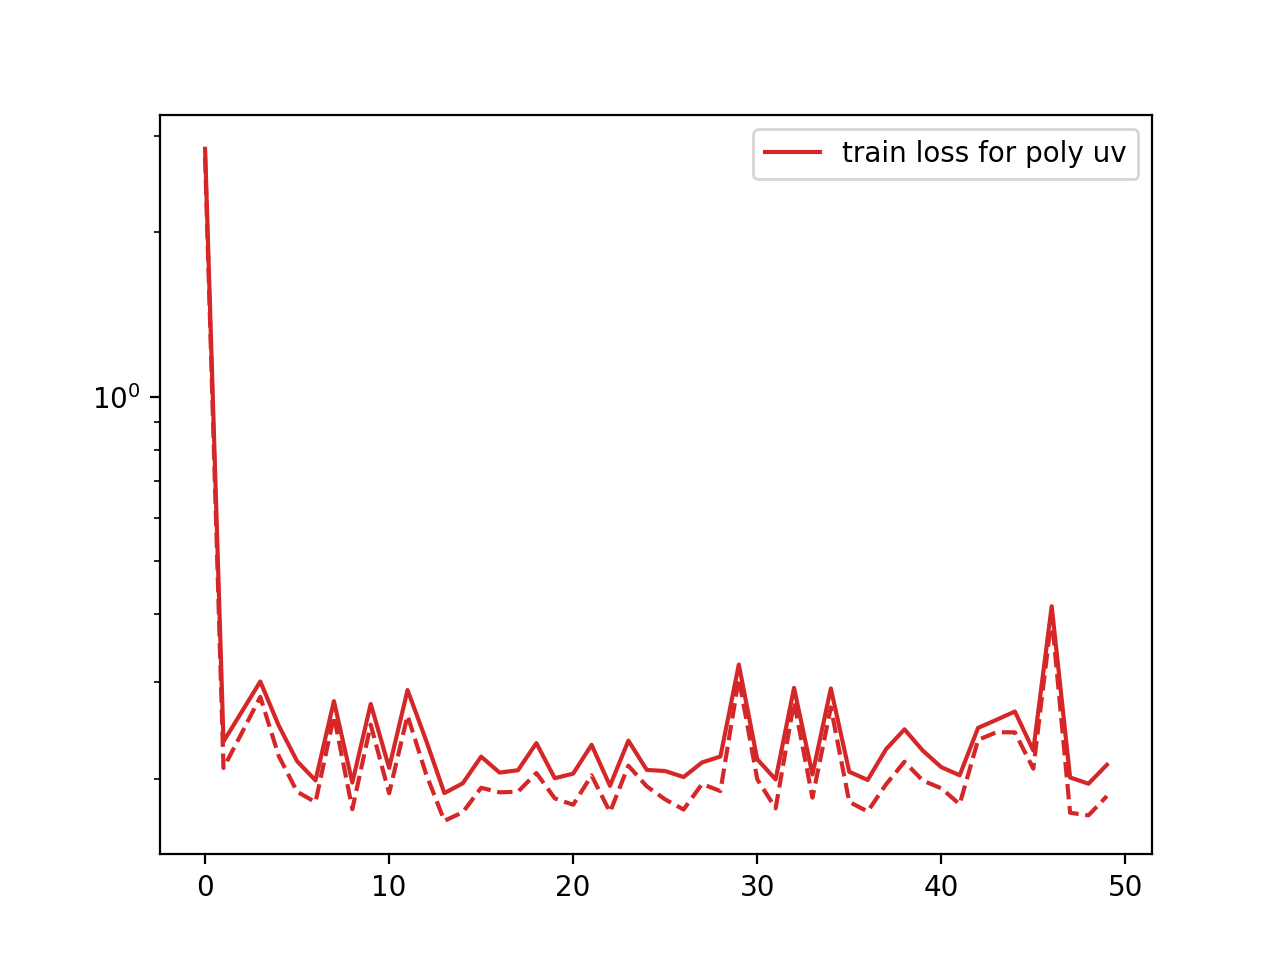

In [12]:
plt.figure()
plt.plot(train_loss_poly, color = 'tab:red', label = 'train loss for poly uv')
plt.plot(test_loss_poly, '--', color = 'tab:red')
plt.legend()
plt.yscale('log')

In [13]:
def check_subgrid_prediction(weights, features_test, target, q, title):
    
    prediction = np.tensordot(weights, features_test, axes = [0, 0]).squeeze()

    temp = target.std()
    clim = [-temp*8, temp*8]
    #clim = [None, None]
    plt.figure(figsize = [9.5, 2])
    plt.suptitle(title)
    plt.subplot(1, 4, 1)
    plt.imshow(target, origin = 'lower', cmap = 'RdBu_r')
    plt.colorbar(); plt.title('Subgrid-scale forcing')
    plt.clim(clim)
    plt.subplot(1, 4, 2)
    plt.imshow(prediction, origin = 'lower', cmap = 'RdBu_r')
    plt.colorbar(); plt.title('Prediction')
    plt.clim(clim)
    plt.subplot(1, 4, 3)
    error = prediction - target
    plt.imshow(error, origin = 'lower', cmap = 'RdBu_r')
    plt.colorbar(); plt.title('Error')
    plt.clim(clim)
    plt.subplot(1, 4, 4)
    plt.imshow(q, origin = 'lower', cmap = 'RdBu_r')
    plt.colorbar(); plt.title('$u$')
    plt.tight_layout()
    plt.clim([-np.abs(q).max(), np.abs(q).max()])

    print(prediction.sum())
    print('Normalized MSE = {0:.3f}'.format(error.var()/target.var()))
    print(r'R^2 = {0:.3f}'.format(np.corrcoef(prediction.reshape(-1), target.reshape(-1))[0,1]))

<IPython.core.display.Javascript object>


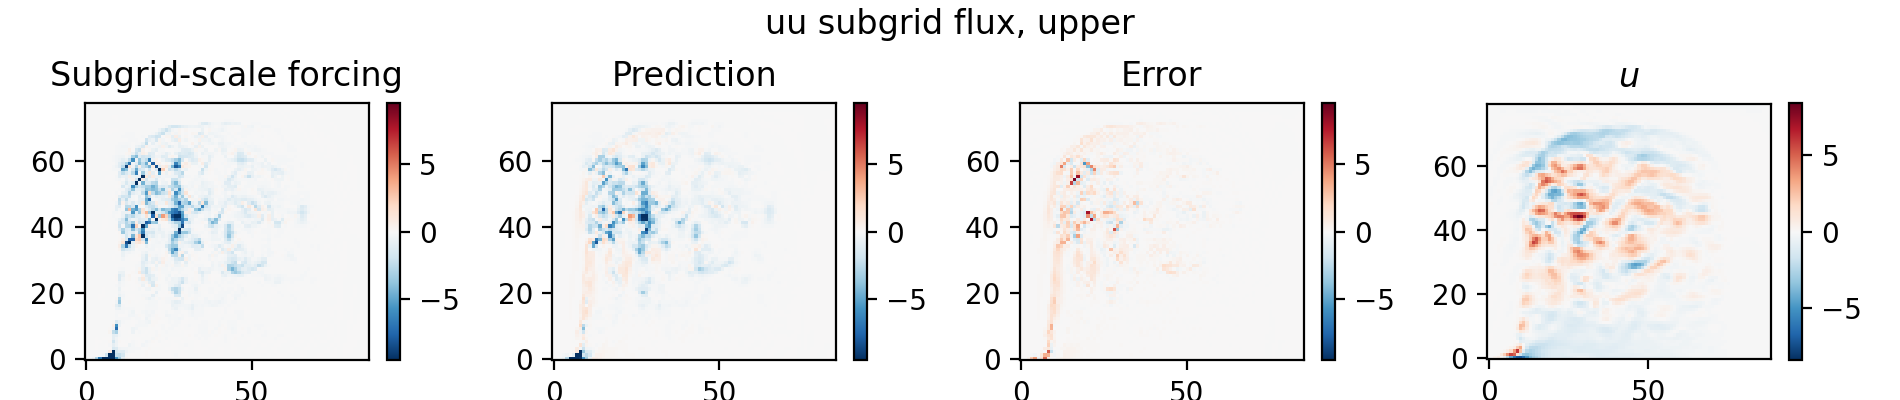

-1448.3916327349102
Normalized MSE = 0.180
R^2 = 0.911


<IPython.core.display.Javascript object>


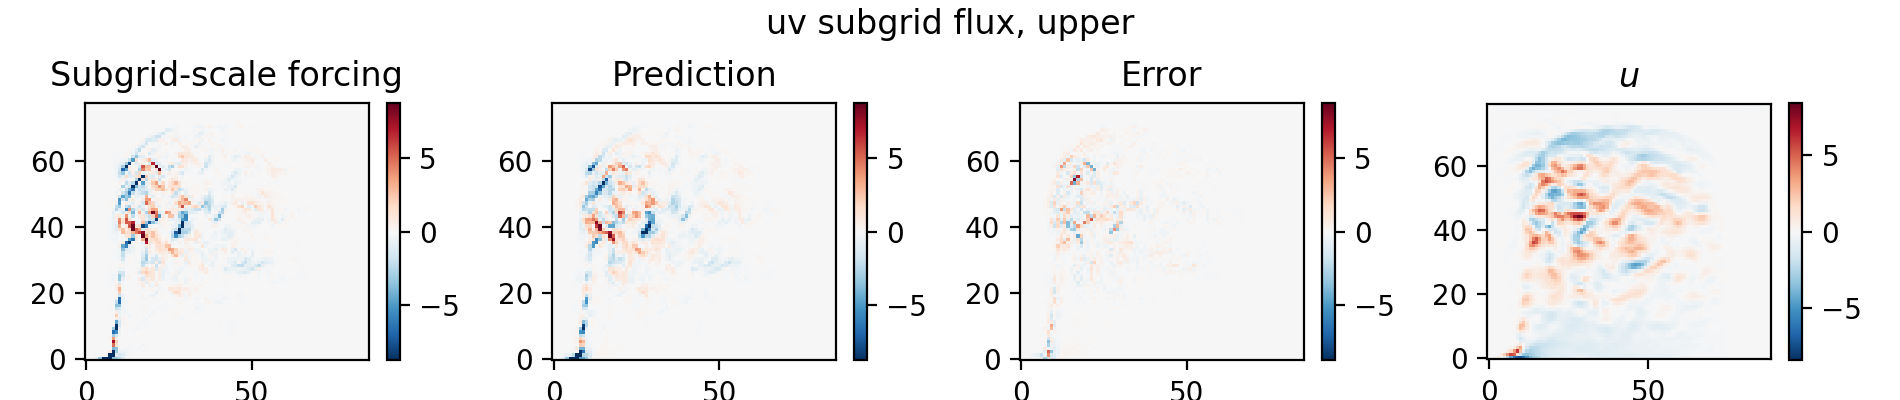

-330.66973328867994
Normalized MSE = 0.151
R^2 = 0.923


<IPython.core.display.Javascript object>


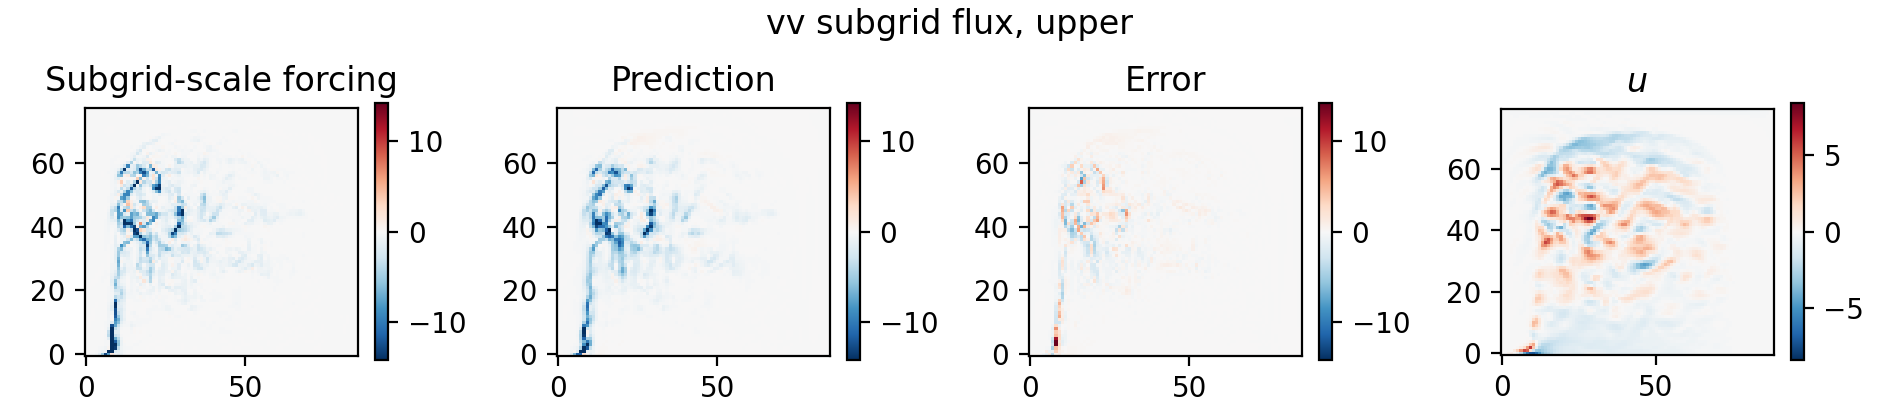

-3474.950905105831
Normalized MSE = 0.188
R^2 = 0.902


<IPython.core.display.Javascript object>


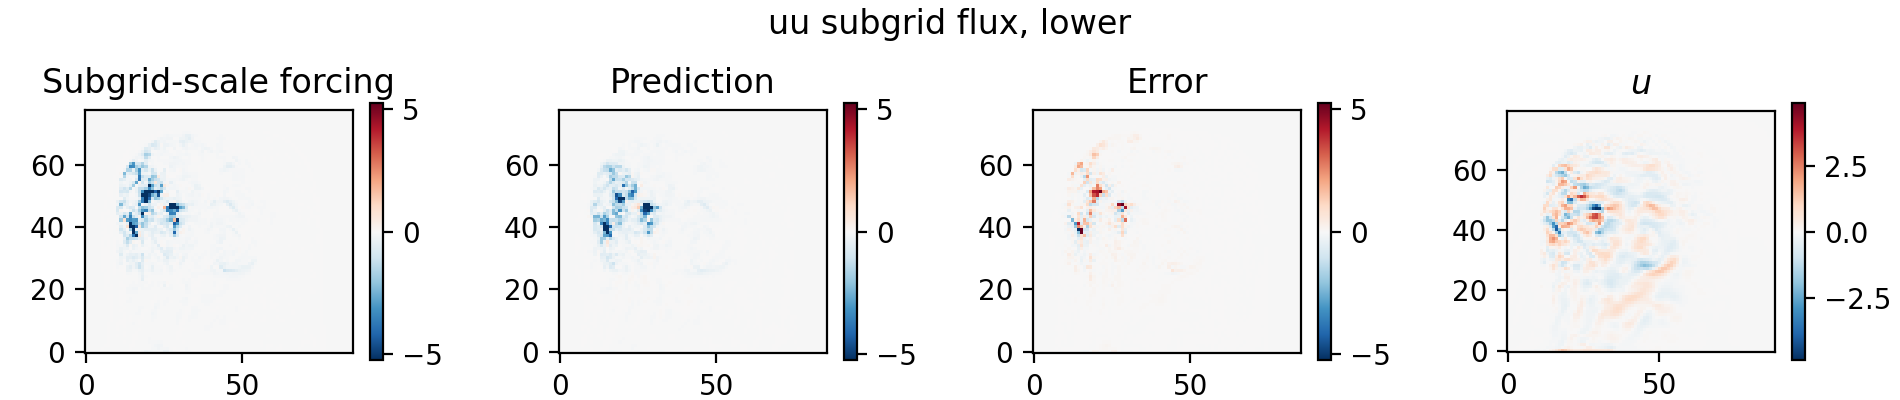

-619.0253827987889
Normalized MSE = 0.214
R^2 = 0.901


<IPython.core.display.Javascript object>


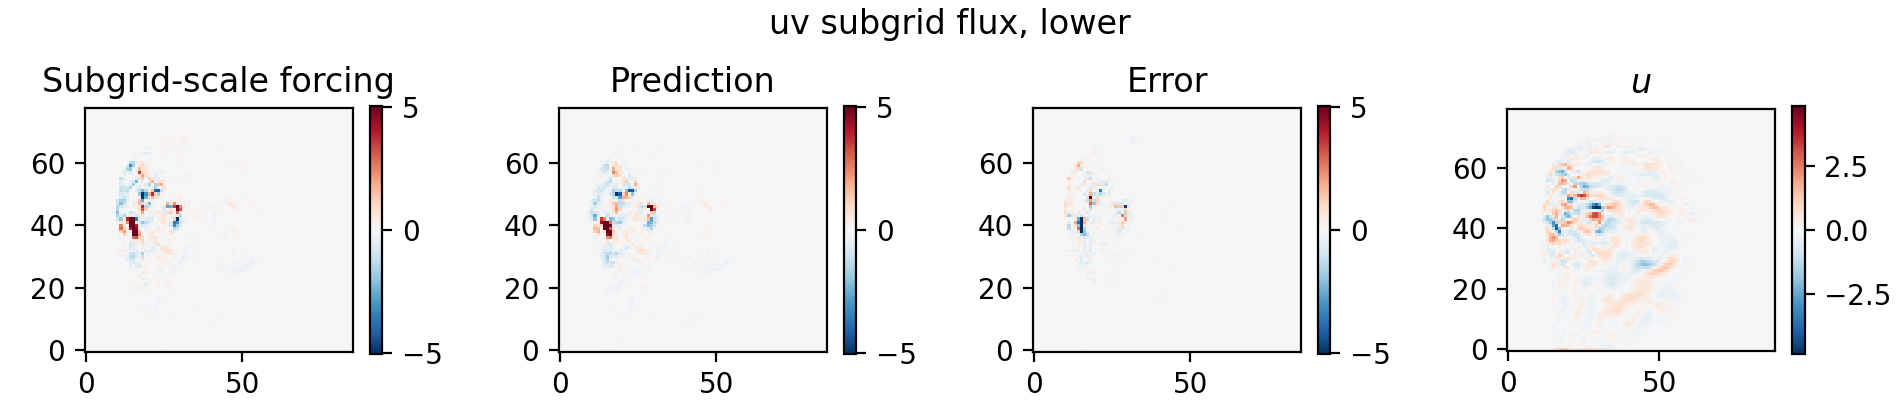

29.77971145481602
Normalized MSE = 0.165
R^2 = 0.932


<IPython.core.display.Javascript object>


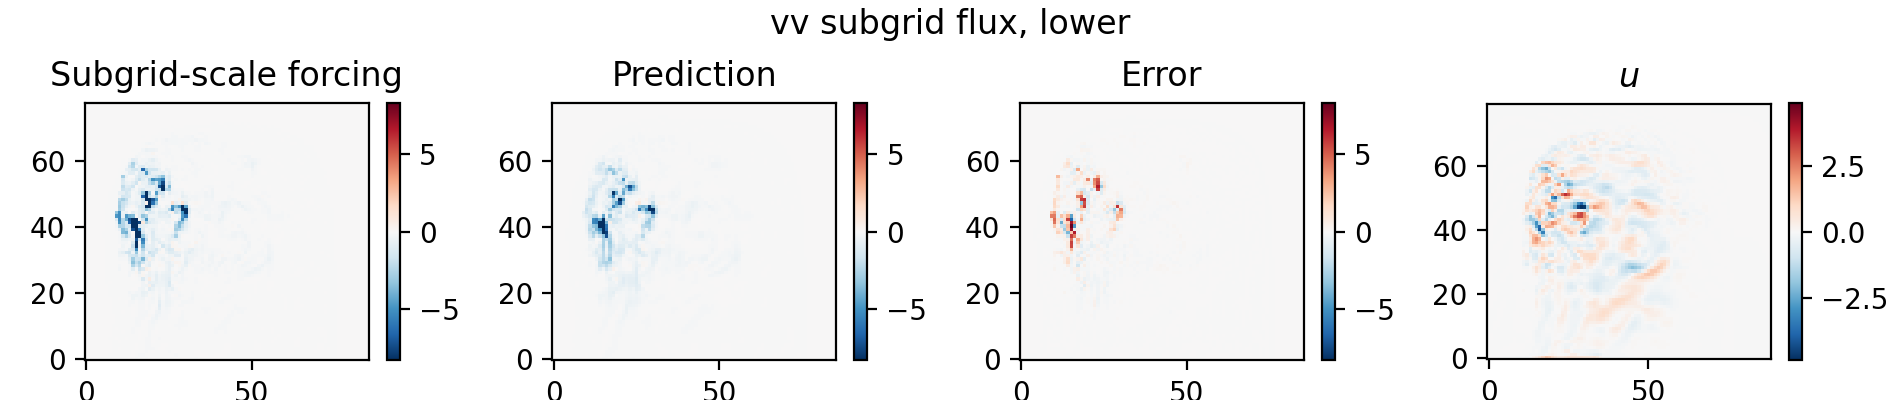

-993.5027570686357
Normalized MSE = 0.226
R^2 = 0.898


In [14]:
t_test = 10
weights_poly = net_poly.linear1.weight.detach().numpy()
weights_uu = weights_poly[0, :].reshape(-1)
weights_uv = weights_poly[1, :].reshape(-1)
weights_vv = weights_poly[2, :].reshape(-1)
features_test1, _, _ = poly_features_uv_staggered(u1[t_test:t_test+1, :, :], v1[t_test:t_test+1, :, :], 
                                   u_ind, v_ind, CROSS_TERMS = CROSS_TERMS, LINEAR_TERMS = LINEAR_TERMS)
features_test2, _, _ = poly_features_uv_staggered(u2[t_test:t_test+1, :, :], v2[t_test:t_test+1, :, :], 
                                   u_ind, v_ind, CROSS_TERMS = CROSS_TERMS, LINEAR_TERMS = LINEAR_TERMS)
check_subgrid_prediction(weights_uu, features_test1, 
                         uu1_subgrid[t_test, :, :], u1[t_test, :, :], 'uu subgrid flux, upper')
check_subgrid_prediction(weights_uv, features_test1, 
                         uv1_subgrid[t_test, :, :], u1[t_test, :, :], 'uv subgrid flux, upper')
check_subgrid_prediction(weights_vv, features_test1, 
                         vv1_subgrid[t_test, :, :], u1[t_test, :, :], 'vv subgrid flux, upper')
check_subgrid_prediction(weights_uu, features_test2, 
                         uu2_subgrid[t_test, :, :], u2[t_test, :, :], 'uu subgrid flux, lower')
check_subgrid_prediction(weights_uv, features_test2, 
                         uv2_subgrid[t_test, :, :], u2[t_test, :, :], 'uv subgrid flux, lower')
check_subgrid_prediction(weights_vv, features_test2, 
                         vv2_subgrid[t_test, :, :], u2[t_test, :, :], 'vv subgrid flux, lower')

<IPython.core.display.Javascript object>


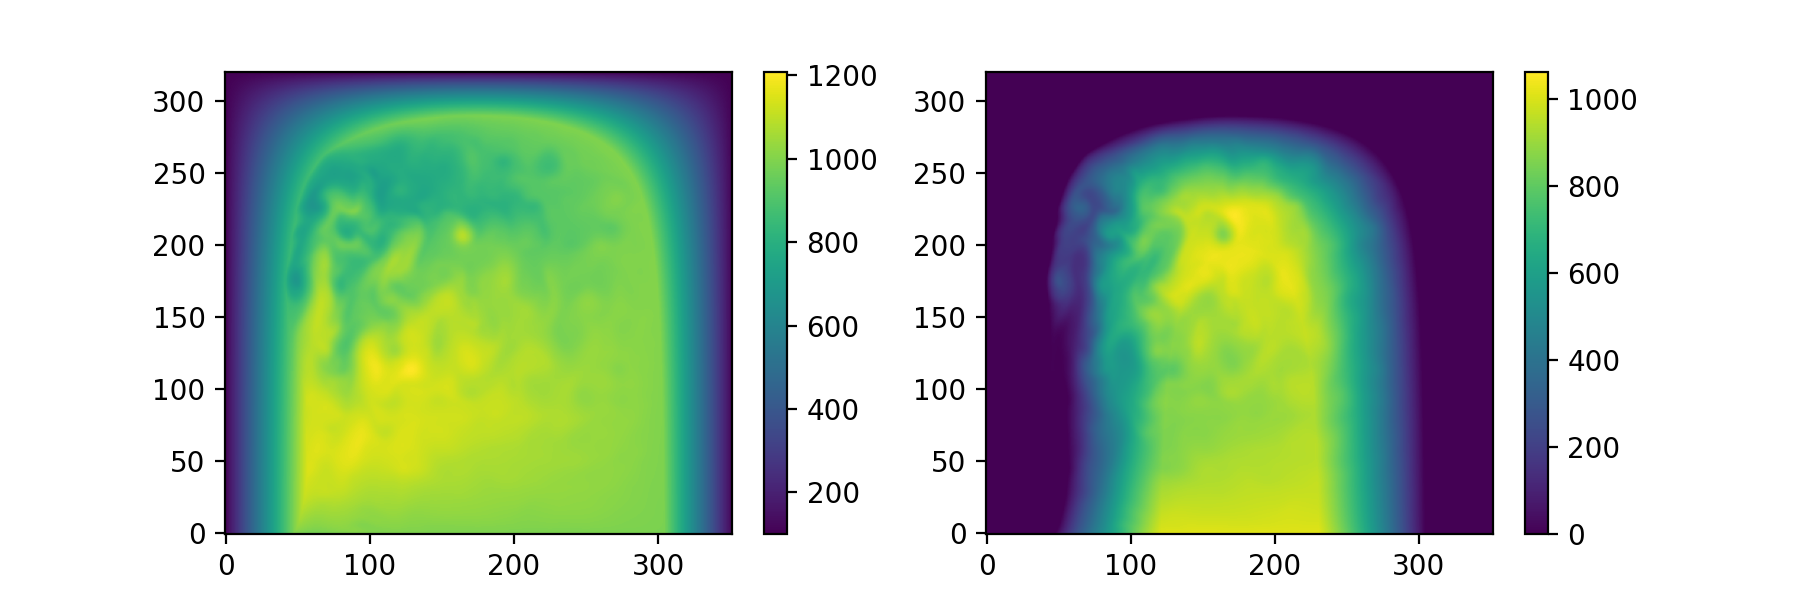

In [15]:
plt.figure(figsize = [9, 3])
plt.subplot(1, 2, 1)
plt.imshow(ds.h[-1, 0, :, :], origin = 'lower')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(ds.h[-1, 1, :, :], origin = 'lower')
plt.colorbar()

## Compare offline spectral contributions with data, polynet, AZ2017 and ZB2020

In [16]:
R = 6.378E+06
dx_c = 1/16/180*np.pi*R*n_scale
dy_c = dx_c

In [17]:
# Known parameterizations
du_zb2020, dv_zb2020, uu_sub_zb2020, vv_sub_zb2020, uv_sub_zb2020 = \
                                zb2020(u_c, v_c, dx = dx_c, dy = dy_c, kappa = -4.87e8 * 0.5)
du_az2017, dv_az2017, uu_sub_az2017, vv_sub_az2017, uv_sub_az2017 = \
                                zb2020(u_c, v_c, dx = dx_c, dy = dy_c, kappa = -4.87e8 * 0.5, AZ2017 = True)
du_data, dv_data = tendencies_from_subgrid(uu_subgrid, uv_subgrid, vv_subgrid, dx = dx_c, dy = dy_c)

In [18]:
# Polynet
features_test1, _, _ = poly_features_uv_staggered(u1, v1, u_ind, v_ind, 
                                                 CROSS_TERMS = CROSS_TERMS, LINEAR_TERMS = LINEAR_TERMS)
uu1_sub_poly = np.tensordot(weights_uu, features_test1, axes = [0, 0]).squeeze() * u1_subgrid_std
uv1_sub_poly = np.tensordot(weights_uv, features_test1, axes = [0, 0]).squeeze() * u1_subgrid_std
vv1_sub_poly = np.tensordot(weights_vv, features_test1, axes = [0, 0]).squeeze() * u1_subgrid_std

features_test2, _, _ = poly_features_uv_staggered(u2, v2, u_ind, v_ind, 
                                                 CROSS_TERMS = CROSS_TERMS, LINEAR_TERMS = LINEAR_TERMS)
uu2_sub_poly = np.tensordot(weights_uu, features_test2, axes = [0, 0]).squeeze() * u1_subgrid_std
uv2_sub_poly = np.tensordot(weights_uv, features_test2, axes = [0, 0]).squeeze() * u1_subgrid_std
vv2_sub_poly = np.tensordot(weights_vv, features_test2, axes = [0, 0]).squeeze() * u1_subgrid_std

uu_sub_poly = np.stack([uu1_sub_poly, uu2_sub_poly], axis = 1)
uv_sub_poly = np.stack([uv1_sub_poly, uv2_sub_poly], axis = 1)
vv_sub_poly = np.stack([vv1_sub_poly, vv2_sub_poly], axis = 1)
del uu1_sub_poly, uv1_sub_poly, vv1_sub_poly, \
    uu2_sub_poly, uv2_sub_poly, vv2_sub_poly, \
    features_test1, features_test2

du_poly, dv_poly = tendencies_from_subgrid(uu_sub_poly, uv_sub_poly, vv_sub_poly, dx = dx_c, dy = dy_c)

<IPython.core.display.Javascript object>


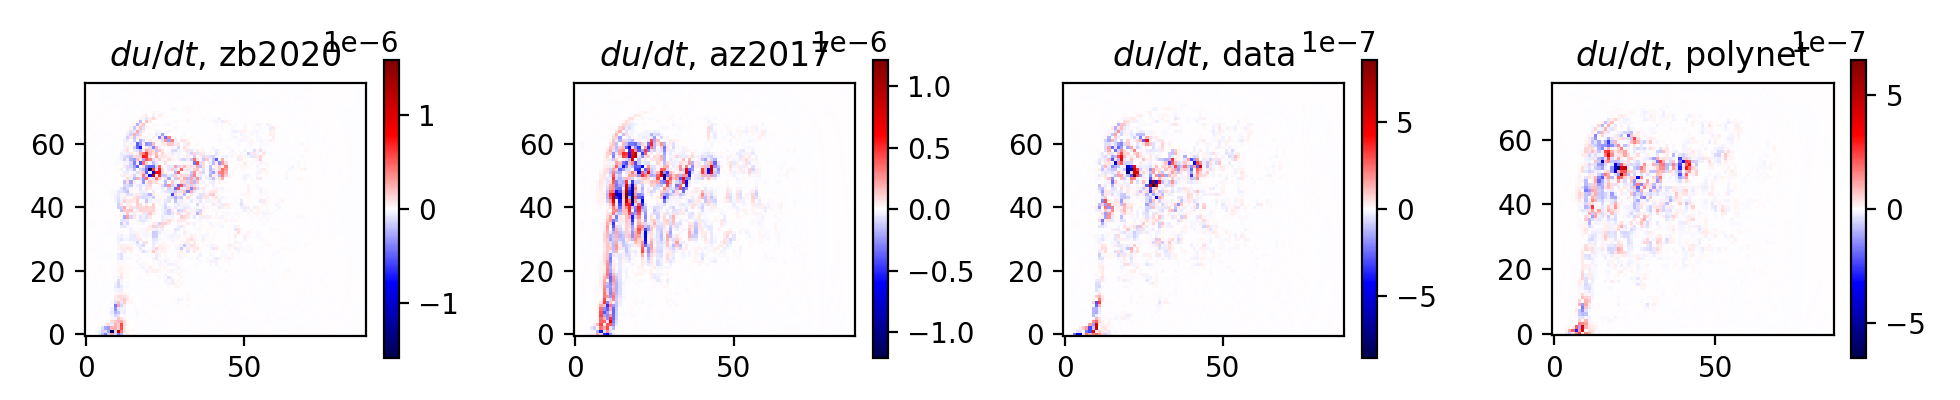

<IPython.core.display.Javascript object>


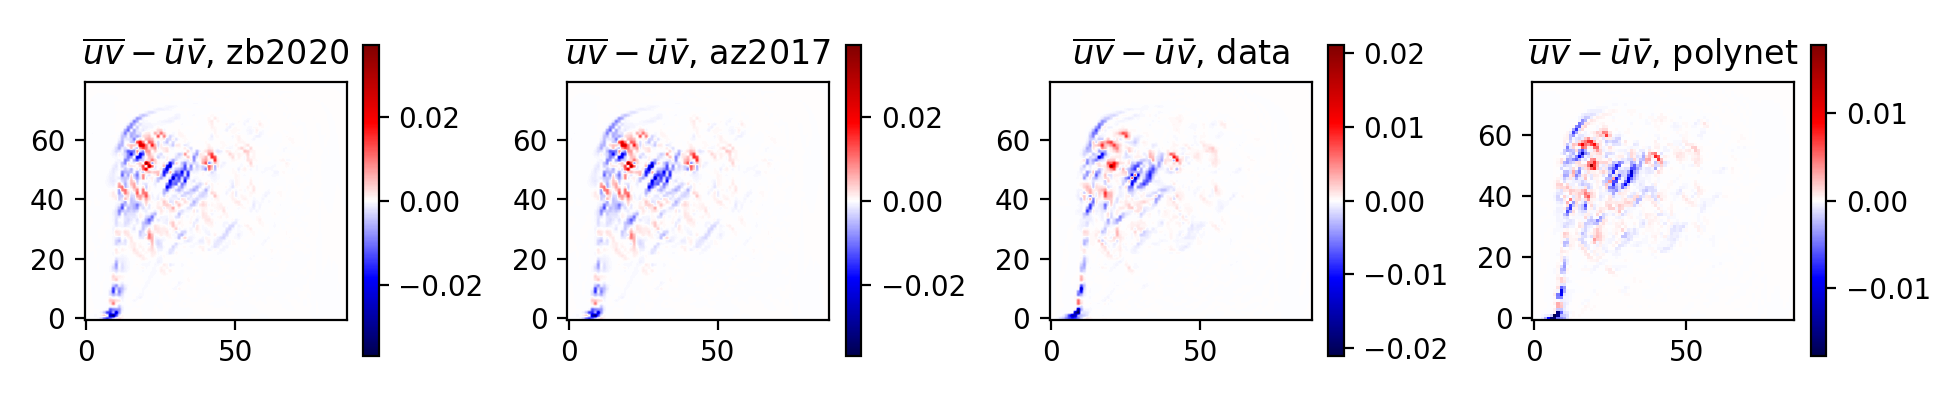

<IPython.core.display.Javascript object>


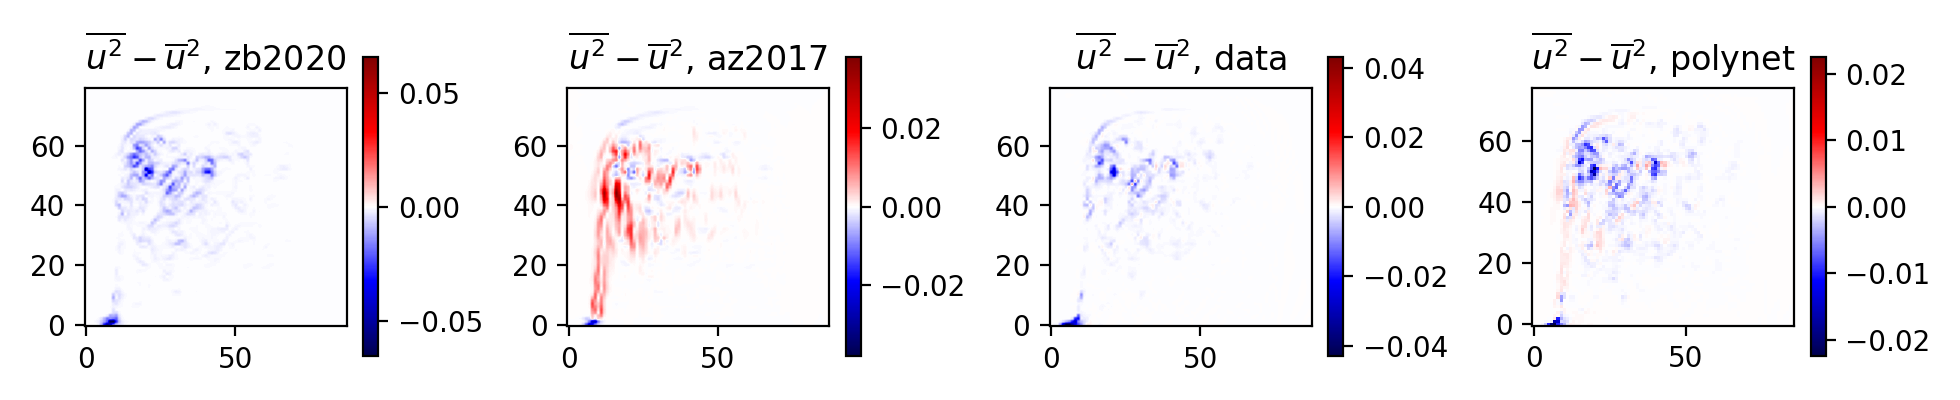

In [19]:
uu_sub_list = [uu_sub_zb2020, uu_sub_az2017, uu_subgrid, uu_sub_poly]
uv_sub_list = [uv_sub_zb2020, uv_sub_az2017, uv_subgrid, uv_sub_poly]
vv_sub_list = [vv_sub_zb2020, vv_sub_az2017, vv_subgrid, vv_sub_poly]
du_list = [du_zb2020, du_az2017, du_data, du_poly]
dv_list = [dv_zb2020, dv_az2017, dv_data, dv_poly]
label_list = ['zb2020', 'az2017', 'data', 'polynet']

plt.figure(figsize = [9.8, 2.])
t_plot = -1
for i, var in enumerate(du_list):
    plt.subplot(1, 4, i+1)
    temp1 = var[t_plot, 0, ...]
    plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
               cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
    plt.title(r'$du/dt$, ' + label_list[i])
plt.tight_layout()

plt.figure(figsize = [9.8, 2.])
t_plot = -1
for i, var in enumerate(uv_sub_list):
    plt.subplot(1, 4, i+1)
    temp1 = var[t_plot, 0, ...]
    plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
               cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
    plt.title(r'$\overline{uv}-\bar{u}\bar{v}$, ' + label_list[i])
plt.tight_layout()

plt.figure(figsize = [9.8, 2.])
t_plot = -1
for i, var in enumerate(uu_sub_list):
    plt.subplot(1, 4, i+1)
    temp1 = var[t_plot, 0, ...]
    plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
               cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
    plt.title(r'$\overline{u^2}-\overline{u}^2$, ' + label_list[i])
plt.tight_layout()

<IPython.core.display.Javascript object>


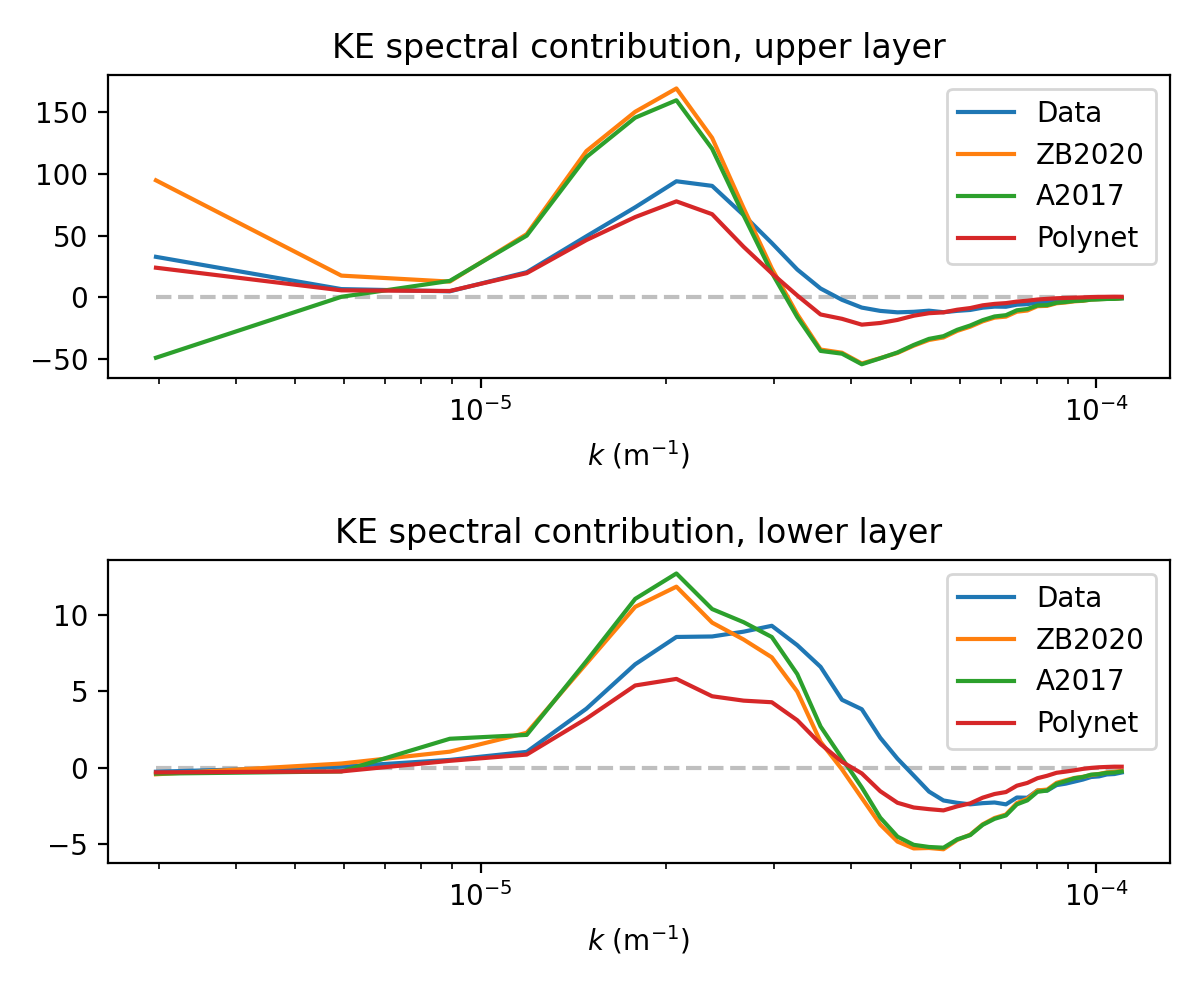

In [20]:
# Spectral contribution
lim = 2
k_data, dS_data = spectral_energy_contribution_staggered(
    u_c[:, :, lim:-lim, lim:-lim], v_c[:, :, lim:-lim, lim:-lim], 
    du_data[:, :, lim:-lim, lim:-lim], dv_data[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_zb2020, dS_zb2020 = spectral_energy_contribution_staggered(
    u_c[:, :, lim:-lim, lim:-lim], v_c[:, :, lim:-lim, lim:-lim], 
    du_zb2020[:, :, lim:-lim, lim:-lim], dv_zb2020[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_az2017, dS_az2017 = spectral_energy_contribution_staggered(
    u_c[:, :, lim:-lim, lim:-lim], v_c[:, :, lim:-lim, lim:-lim], 
    du_az2017[:, :, lim:-lim, lim:-lim], dv_az2017[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_poly, dS_poly = spectral_energy_contribution_staggered(
    u_c[:, :, lim:-lim, lim:-lim], v_c[:, :, lim:-lim, lim:-lim], 
    du_poly[:, :, lim-bnd:Ny_c-lim-bnd, lim-bnd:Nx_c+1-lim-bnd], 
    dv_poly[:, :, lim-bnd:Ny_c+1-lim-bnd, lim-bnd:Nx_c-lim-bnd], 
    dx_c, dy_c, WINDOW = True)

plot_spectral_contribution([k_data, k_zb2020, k_az2017, k_poly], 
                           [dS_data, dS_zb2020, dS_az2017, dS_poly], 
                           ['Data', 'ZB2020', 'A2017', 'Polynet'], 
                           'KE spectral contribution')

<IPython.core.display.Javascript object>


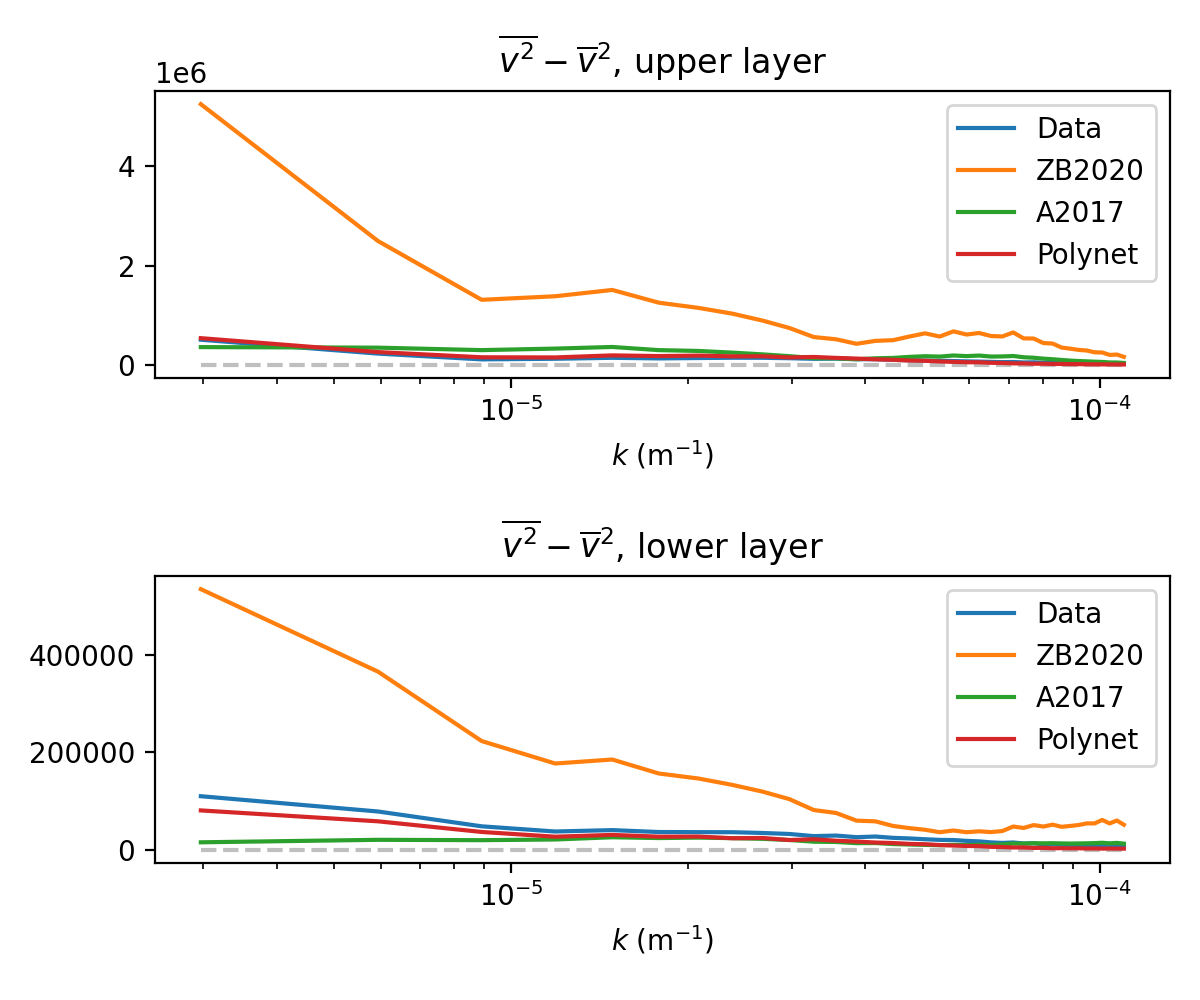

In [21]:
# Spectral flux spectra
lim = 2
k_data  , S_data   = spectral_energy(vv_subgrid   [:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_zb2020, S_zb2020 = spectral_energy(vv_sub_zb2020[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_az2017, S_az2017 = spectral_energy(vv_sub_az2017[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_poly  , S_poly   = spectral_energy(vv_sub_poly  [:, :, lim-bnd:Ny_c-lim-bnd, lim-bnd:Nx_c+1-lim-bnd], 
                                 dx_c, dy_c, WINDOW = True)

plot_spectral_contribution([k_data, k_zb2020, k_az2017, k_poly], 
                           [S_data, S_zb2020, S_az2017, S_poly], 
                           ['Data', 'ZB2020', 'A2017', 'Polynet'], 
                           '$\overline{v^2}-\overline{v}^2$')

<IPython.core.display.Javascript object>


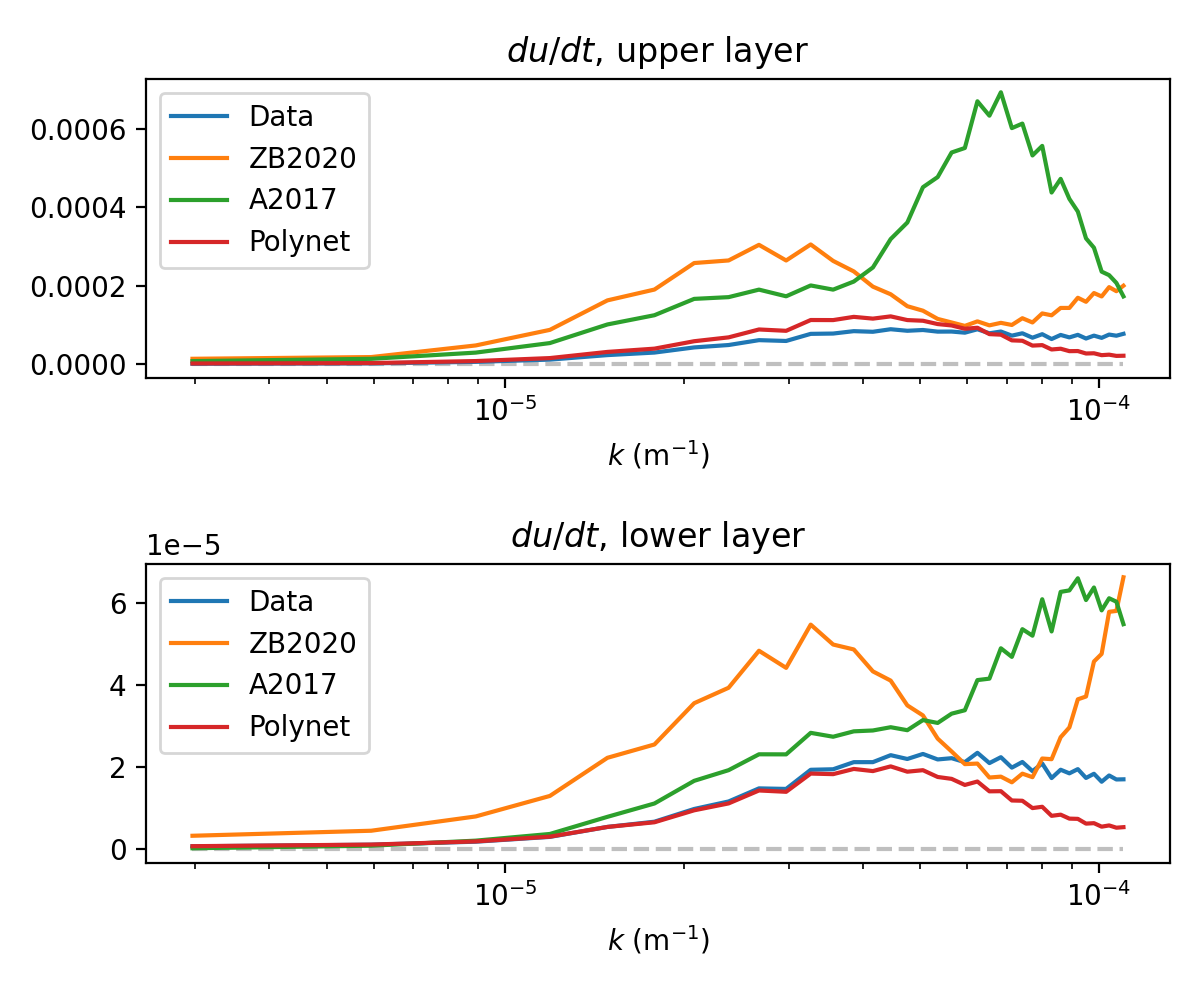

In [22]:
# Spectra of tendency
lim = 2
k_data  , S_data   = spectral_energy(du_data   [:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_zb2020, S_zb2020 = spectral_energy(du_zb2020[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_az2017, S_az2017 = spectral_energy(du_az2017[:, :, lim:-lim, lim:-lim], dx_c, dy_c, WINDOW = True)
k_poly  , S_poly   = spectral_energy(du_poly  [:, :, lim-bnd:Ny_c-lim-bnd, lim-bnd:Nx_c+1-lim-bnd], 
                                 dx_c, dy_c, WINDOW = True)

plot_spectral_contribution([k_data, k_zb2020, k_az2017, k_poly], 
                           [S_data, S_zb2020, S_az2017, S_poly], 
                           ['Data', 'ZB2020', 'A2017', 'Polynet'], 
                           '$du/dt$')

In [103]:
## Plot data with different resolutions
Rs = [2, 4, 8, 16]
path_pattern = '/scratch/zl1574/mom6_simulation/double_gyre_R{0}_cartesian_100yr/output/'
ks, dSs, labels = cal_spectral_contribution_diff_res(Rs, np.arange(6, 10), path_pattern)
dxs = [1/r/180*np.pi*6.378E+06 for r in Rs]
plot_spectral_contribution(ks, dSs, labels, 'Normalized KE spectral contribution', dxs = dxs)

<IPython.core.display.Javascript object>


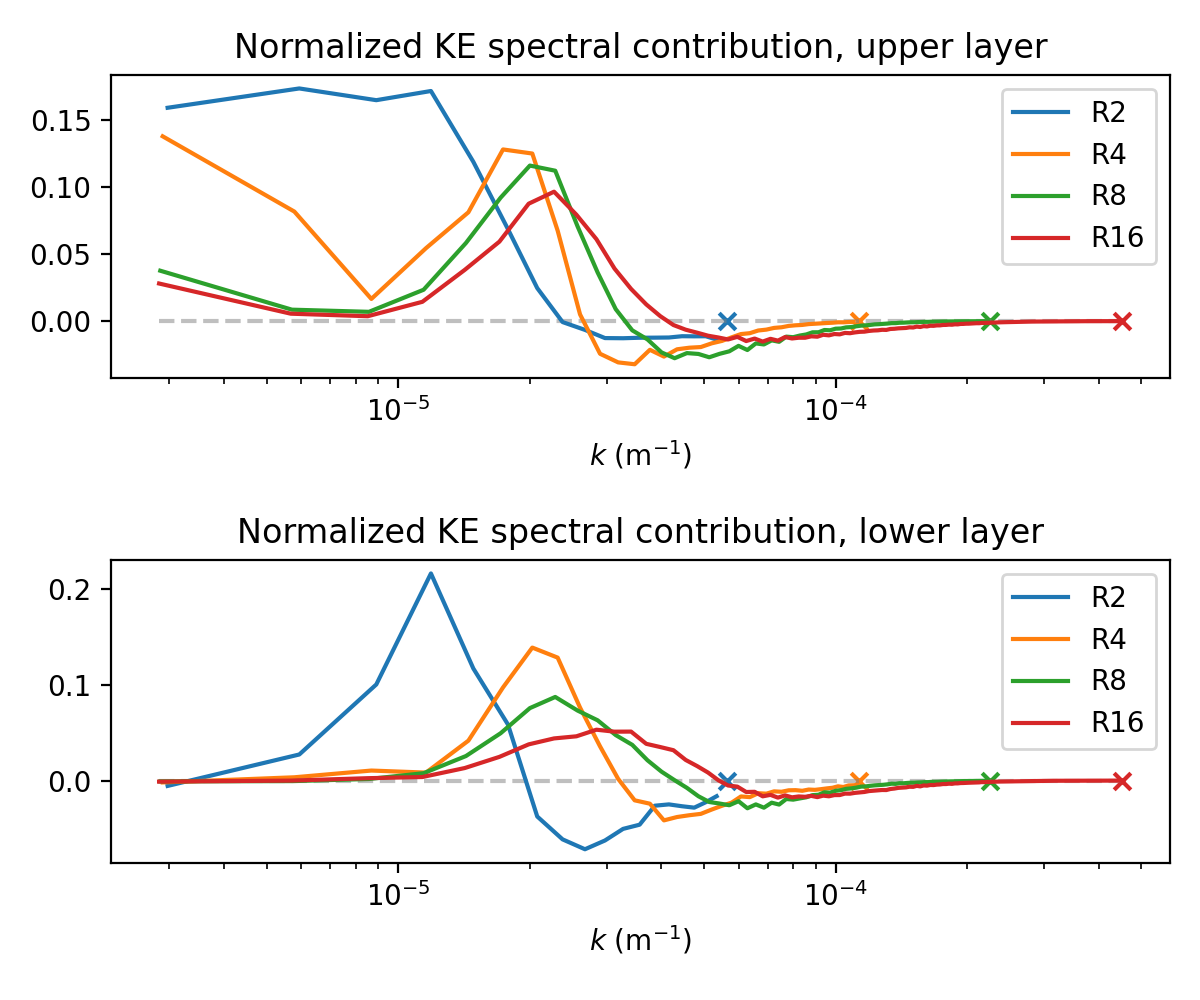

In [ ]:
## Plot data with different resolutions, Pavel's data
Rs = [2, 4, 8, 16, 32]
path_pattern = '/scratch/zanna/data/mom6/Feb2022/bare/R{0}/output/'
ks, dSs, labels = cal_spectral_contribution_diff_res(Rs, np.arange(1, 3), path_pattern)
plot_spectral_contribution(ks, dSs, labels, 'Normalized KE spectral contribution, Pavel')

<IPython.core.display.Javascript object>


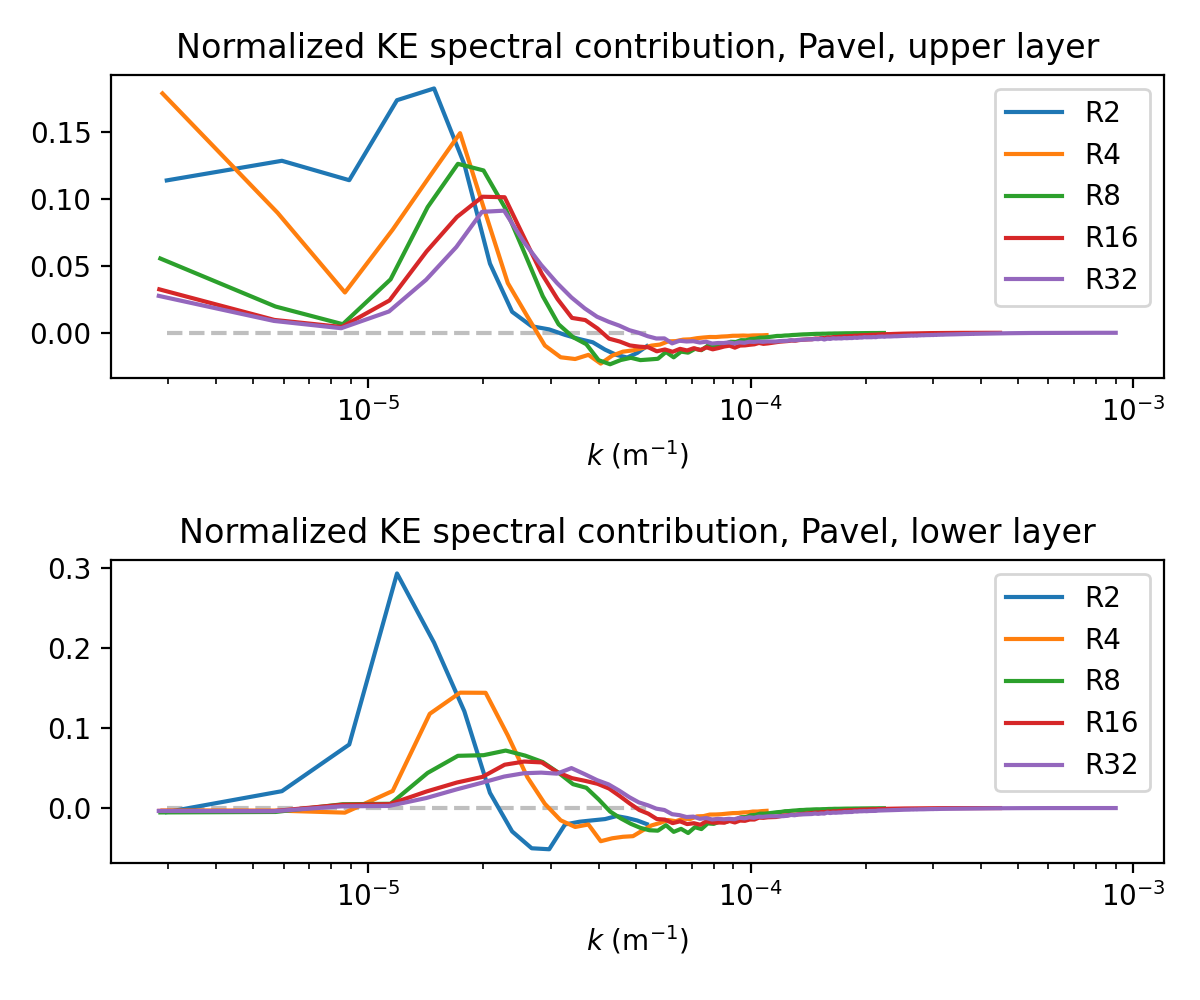

In [80]:
## Plot data with different resolutions, Pavel's parameterized data
Rs = [4, 8]
path_pattern = '/scratch/zanna/data/mom6/Feb2022/ZB2020/R{0}/FGR2/output/'
ks, dSs, labels = cal_spectral_contribution_diff_res(Rs, np.arange(1, 3), path_pattern)
plot_spectral_contribution(ks, dSs, labels, 'Normalized KE spectral contribution, Pavel')

/scratch/zanna/data/mom6/Feb2022/ZB2020/R{0}/FGR2/output/
/scratch/zanna/data/mom6/Feb2022/ZB2020/R{0}/FGR2/output/


<IPython.core.display.Javascript object>


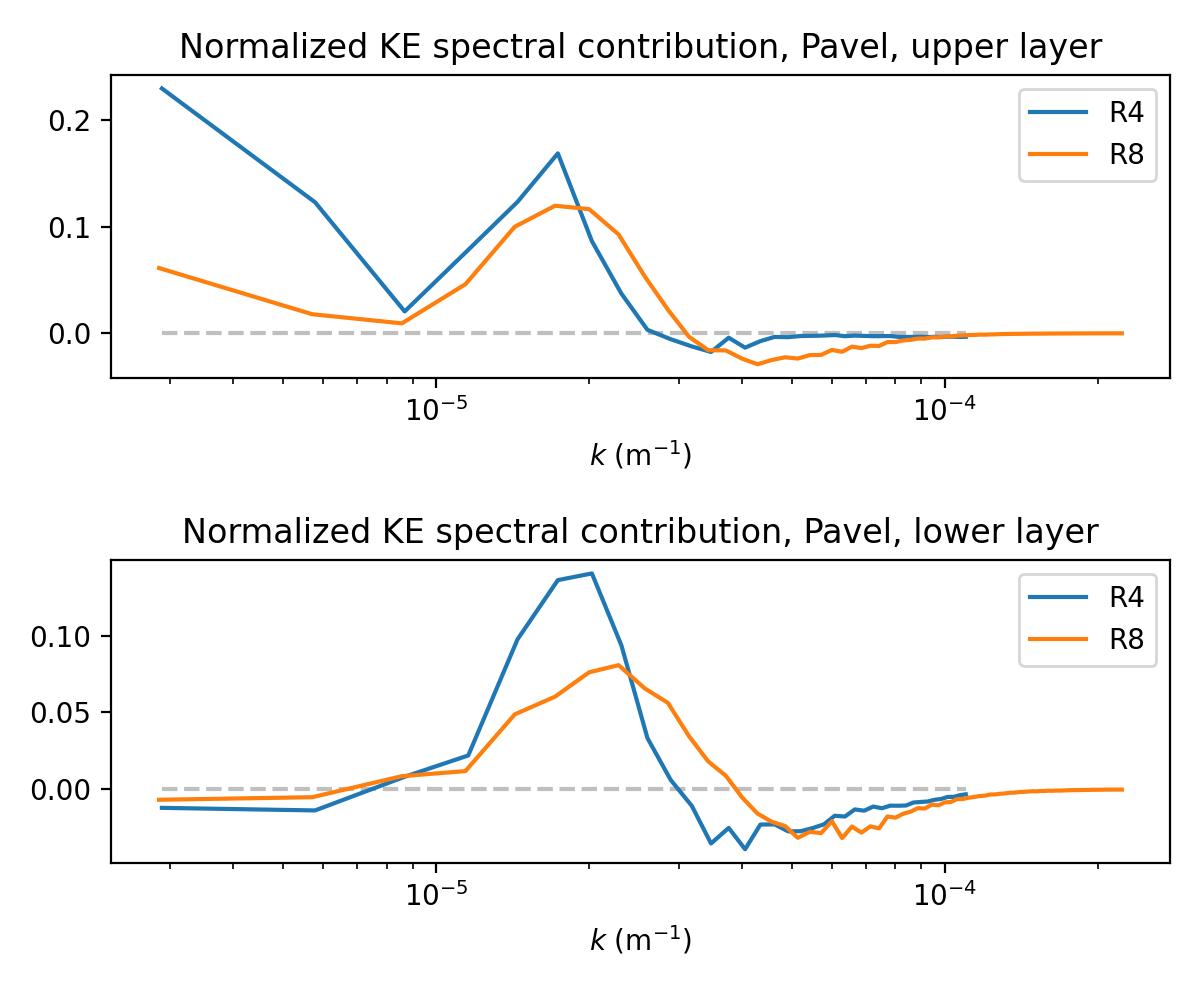

<IPython.core.display.Javascript object>


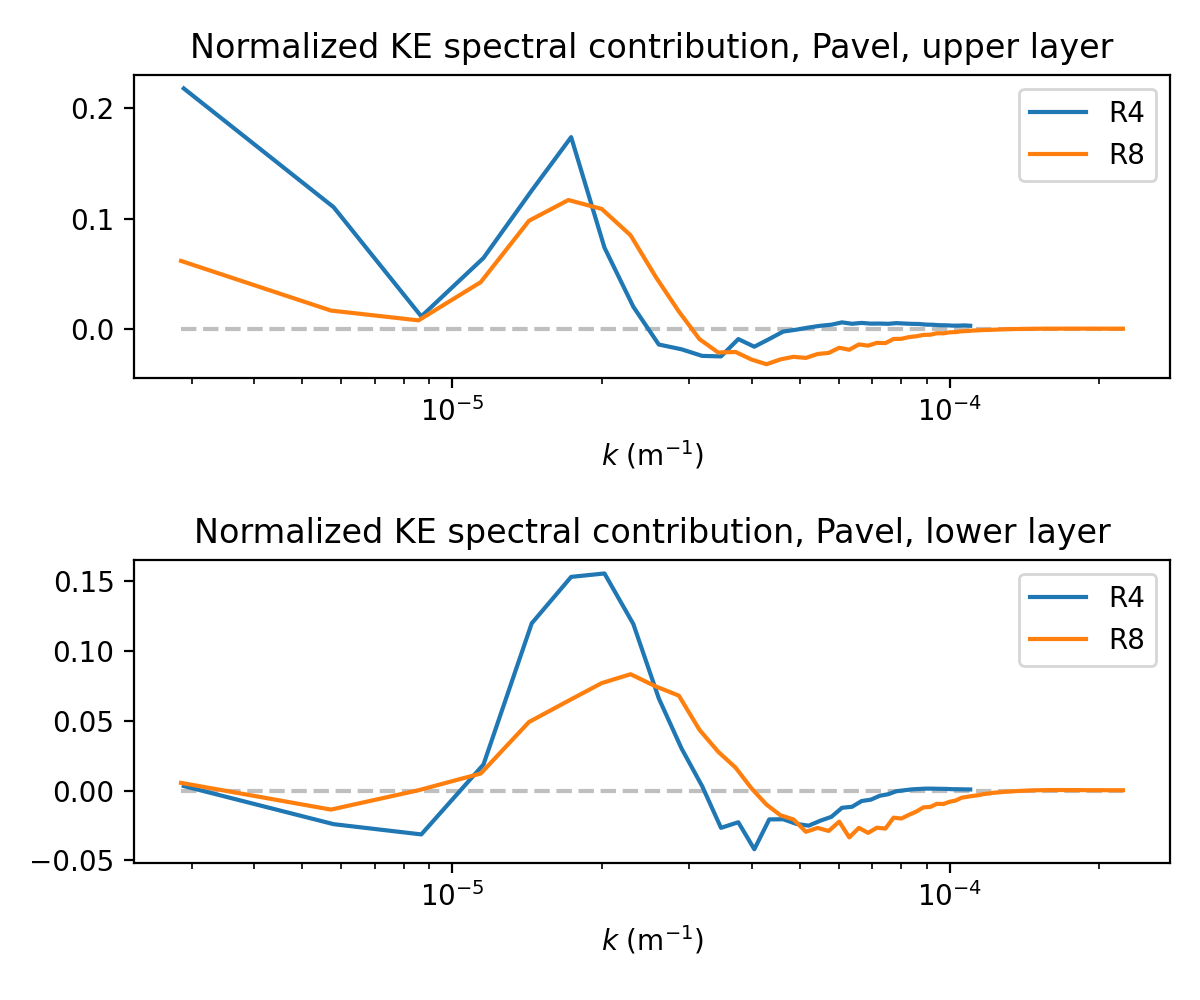

In [98]:
## Plot data with different resolutions, Pavel's parameterized simulations with his tendencies
Rs = [4, 8]; ts = np.arange(1, 3)
path_pattern = '/scratch/zanna/data/mom6/Feb2022/ZB2020/R{0}/FGR2/output/'
ks, dSs, labels = cal_spectral_contribution_diff_res(Rs, ts, path_pattern, OFFLINE_TENDENCIES = False)
plot_spectral_contribution(ks, dSs, labels, 'Normalized KE spectral contribution, Pavel')